# Import libraries & load the data

In [3]:
# Import packages for the data analysis
import pandas as pd
import numpy as np

In [ ]:
# Load dataset
df = pd.read_csv('../data/tidy-scooters.csv',index_col ='TripID', parse_dates = ['Start', 'End'])

In [ ]:
df.describe()

,Duration,Distance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
count,535807.000000,535807.000000,535807.000000,535807.000000,535807.000000,535807.000000,535807.000000,535807.000000
mean,14.785329,1701.184645,38.241013,-85.748863,38.239418,-85.746312,4.295502,14.251594
std,20.878673,2322.028584,0.041762,0.202535,0.233208,0.600207,2.061110,4.659727
min,0.000000,0.000000,25.778000,-122.666000,0.000000,-122.675000,1.000000,0.000000
25%,4.000000,257.000000,38.222000,-85.759000,38.222000,-85.759000,3.000000,11.000000
50%,8.000000,917.000000,38.251000,-85.755000,38.250000,-85.755000,4.000000,15.000000
75%,17.000000,2188.000000,38.256000,-85.744000,38.256000,-85.743000,6.000000,18.000000
max,3167.000000,32180.000000,50.110000,8.674000,50.117000,8.685000,7.000000,23.000000


# Further data processing

## Sort Outliers

Take out trips longer than 100 minutes

In [ ]:
df = df.loc[df.Duration <= 100]
df.shape

(531680, 10)

## 'Split' the data

Because there are too many observations for length smaller than 100m and we want to model this behavior in 'short trip' and 'long trip'.

In [ ]:
# print the number of trips with shorter than 10 meters

len(df.loc[df['Distance'] < 100].index)

107235

We create a column for the dummy variable `ShortTrip`

In [ ]:
df['ShortTrip'] = np.where(df['Distance'] < 100, 1, 0)

We can find the ratio between the two proportions:

In [ ]:
len(df.loc[df.ShortTrip == 1].index) / len(df.loc[df.ShortTrip == 0].index)

0.252647575068619

In [ ]:
trips = df.loc[df.ShortTrip == 0]
trips.shape

(424445, 11)

# Duration exploratory analysis

First, let's change the type

In [ ]:
trips['Duration'].astype('int32')

TripID
00006088-2579-e0d0-6a30-a15bb878         6
00008c1a-899b-8596-970f-9f6bf495         6
00009301-3225-2aea-a84a-165a480a         7
000096c8-bac3-4d6f-7ebb-30b957ee         7
0000f36b-a0c7-0378-3f34-e0fb80f6        32
                                        ..
0c2dead5-9296-571c-ab30-0f647ffcd531    22
3a812dca-b083-5e88-a59c-fdf19f14f769    84
ac526223-0238-50f1-8591-5965e7114059    33
e0c07dd2-3257-5138-82ae-d520c9ef8e1f     7
1a7e9820-615e-5918-9ae6-ec5256332b20     9
Name: Duration, Length: 424445, dtype: int32

Then, let's find the trips with 'duration' set to zero and round it to 1. It will be relevant for later.

In [ ]:
len(trips.loc[trips.Duration == 0].index)

107

In [ ]:
trips['Duration'].replace(0,1, inplace = True)

## Some Plotting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

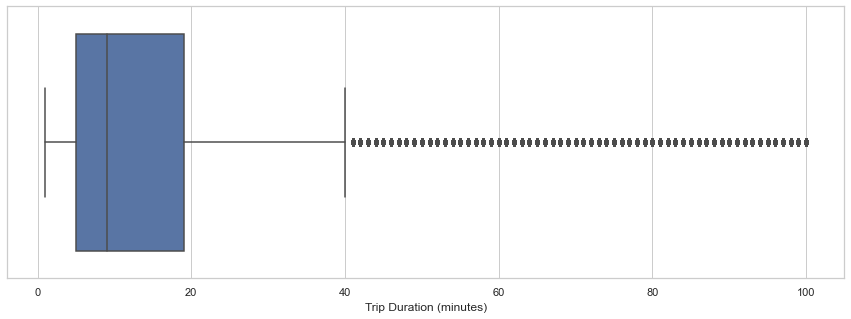

In [ ]:
# visualization boxplot duration <= 100 minutes 

fig, ax = plt.subplots(figsize = (15,5))

ax = sns.boxplot(x = 'Duration', data = trips)
plt.xlabel('Trip Duration (minutes)')

plt.show()

Let's see the distribution of the data:

Text(0, 0.5, 'Counts')

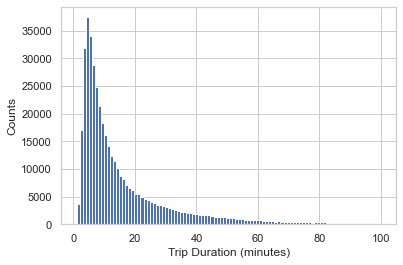

In [ ]:
plt.hist(trips.Duration, bins = 100)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Counts")

## Fitting the data into a distribution

In [ ]:
import scipy

Let's try and see how a lognormal distribution fits the data:

> In probability theory, a log-normal (or lognormal) distribution is a continuous probability distribution of a random variable whose logarithm is normally distributed. Thus, if the random variable X is log-normally distributed, then Y = ln(X) has a normal distribution.

As a reference, see here: https://stackoverflow.com/questions/36795949/python-testing-if-my-data-follows-a-lognormal-distribution

In [ ]:
# scipy.stats.lognorm does calculate the distribution parameters using maximum likelihood estimation.
shape, loc, scale = stats.lognorm.fit(trips.TripDuration)

In [ ]:
print('shape: {}, location: {}, scale: {};'.format(shape, loc, scale))

# scale close to 1 does not surprise, because of the central limit theorem
mu, sigma = np.log(scale), shape

print('the mean mu is the log of the scale: {}; \nsigma is just the shape: {}'.format(mu, sigma))

Let's plot the fitted distribution against the data.

First, we need to define x as the domain of our fitted distributions' probability density function (pdf).

In [4]:
x = np.linspace(1, 100, 100)

Then, we create the fitted distribution's pdf out of x and the parameters we found:

In [ ]:
fitted_data = scipy.stats.lognorm.pdf(x, shape, loc, scale)

And finally we plot it against the histogram:

In [ ]:
plt.hist(df.TripDistance, bins = 100)
plt.plot(x, fitted_data, 'r-')

The location was negative when including TimeDuration == 0 (that's why we rounded the data). One can also bound location to zero with `floc = 0` (see https://stackoverflow.com/questions/8747761/scipy-lognormal-distribution-parameters)


### Testing for fit

We employ the Kolmogorov-Smirnov (KS) test for assessing if the data is lognormally distributed.

> The hypothesis regarding the distributional form **is rejected** if the test statistic, **D, is greater than the critical value** obtained from a table.

In [ ]:
# kolmogorov smirnov test

data = df['TripDuration'].to_numpy(np.float64)

# the command requires specifying the parameters of the target distribution
stats.kstest(data, stats.lognorm.cdf, args = (shape, loc, scale))

Of course, we must reject the hypotheses! No data can be fit into any distribution: it just approximates it! We can only find the distribution that better approximates our sample. An alternative check is drawing the Q-Q plot (see https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0):

In [ ]:
#  observations
observations = trips.TripDuration

# standardise the observations
#z = (observations-np.mean(observations))/np.std(observations)

stats.probplot(observations, dist='lognorm', plot=plt)
plt.title('Q-Q plot')

# Distance exploratory analysis

In [ ]:
# visualization boxplot duration <= 100 minutes 

fig, ax = plt.subplots(figsize = (15,5))

ax = sns.boxplot(x = 'TripDistance', data = df)
plt.xlabel('Trip Distance (meters)')

In [ ]:
# Histogram Trip Distance (meters)
plt.hist(df.TripDistance, bins = 100)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Counts")

## Fitting the data into a distribution, again

First, fit the data:

In [ ]:
scale, loc, shape = scipy.stats.lognorm.fit(df.TripDistance)

Then, define the linspace and draw the pdf.

In [ ]:
x2 = np.linspace(1, 10000, 100)

fitted_data = scipy.stats.lognorm.pdf(x2, scale, loc, shape)

Finally, plot it:

In [ ]:
plt.hist(df.TripDistance, bins = 100)
plt.plot(x, fitted_data, 'r-')